# Metropolis Sampling

#### Marcel Lüthi, Departement of Mathematics and Computer Science, University of Basel

In this notebook we will present an implementation of the Metropolis algorithm and experiment with it. As a target distribution we will use a bivariate normal distribution. This simple setup is ideally suited for exploring the properties of the algorithm: We know how the true target distribution looks like, can change its shape, and we can visualize the samples. 

The intuition that we develop while experimenting with this simple examples, will help us to understand the more complicated cases that we will explore later in this course. 

### Preparation

Before we start, we need to download the plotting library [EvilPlot](https://cibotech.github.io/evilplot/) and make it available in the Jupyter-Notebook. It may take some time when you execute the following cells for the first time. 

In [32]:
interp.repositories() ++= Seq(
  coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
)

In [33]:

import $ivy.`com.cibo::evilplot-repl:0.8.0`
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.renderers.PointRenderer

import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.Point
import com.cibo.evilplot.colors._

import breeze.linalg.{DenseVector, DenseMatrix}
import breeze.stats.distributions.MultivariateGaussian 

def showPlot(plot: com.cibo.evilplot.geometry.Drawable) = 
  Image.fromRenderedImage(plot.asBufferedImage, Image.PNG)


import $ivy.$                              

import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.renderers.PointRenderer


import com.cibo.evilplot.plot.aesthetics.DefaultTheme._

import com.cibo.evilplot.numeric.Point

import com.cibo.evilplot.colors._


import breeze.linalg.{DenseVector, DenseMatrix}

import breeze.stats.distributions.MultivariateGaussian 


defined function showPlot

We also initialize a global random number generator, which we use whenever we need a new random number in our algorithm.

In [20]:
// We keep random number generator around as global state
val rng = new scala.util.Random()

rng: scala.util.Random = scala.util.Random@75a98b76

### The Metropolis algorithm

The Metropolis algorithm works by simulating a random path through the states on which the target distribution is defined. Starting from a given state, a possible new state is proposed using a proposal function. The new state is then evaluated given the target distribution and rejected or accepted depending on the likelihood ratio between the old and new state.

This motivates the following definitions:

In [187]:
type State = DenseVector[Double]  // The state is represented as a vector

defined type State

In [188]:
type Proposal = State => State    // The proposal function produces a new state from a given state

defined type Proposal

In [191]:
type DistributionEvaluator = State => Double // The distribution evaluator evaluates a probability of each state

defined type DistributionEvaluator

In order to understand and be able to visualize how the Metropolis algorithm walks through the state-space, we introduce a logger. The logger keeps track of the sequence of states, together with the information, which new state was proposed in each step:

In [193]:

class Logger {
    case class StepInfo(state : State, proposedState : State) {
        def accepted : Boolean = state == proposedState
    }

    private val stepSeq = collection.mutable.Buffer[StepInfo]()
    
    def steps : Seq[StepInfo] = stepSeq.toSeq
    
    def logStep(state : State, proposedState : State) : Unit = stepSeq.append(StepInfo(state, proposedState))
}

defined class Logger

With these definitions, we are ready to implement the Metropolis sampler. 

In [194]:


def metropolisSampler(p : DistributionEvaluator, q : Proposal, initialState : State, logger : Logger) : Iterator[State] = {

    // Simulates one step
    def nextStep(currentState : State) : State = {
        
        // propose a new state from the given state
        val proposedState = q(currentState) 
        
        // accept based on the ratio of probabilities between 
        // the new and the old state
        val r = rng.nextDouble()
        val alpha  = scala.math.min(1.0, p(proposedState) / p(currentState));
        val nextState = if (r < alpha) proposedState else currentState
        logger.logStep(nextState, proposedState)
        nextState
    }
    
    // create an iterator starting from the initial state
    Iterator.iterate(initialState)(nextStep)
}


defined function metropolisSampler

This is it - this simple code is a complete implementation of the celebrated Metropolis algorithm! 

### Toy example: sampling from a bivariate normal

We will now run the algorithm on a toy example, where we sample from a bivariate normal distribution. 
We start by defining the target probability distribution. 

In [197]:
val bivariateNormal = MultivariateGaussian(
    mean = DenseVector(9.0, 10.0), 
    covariance = DenseMatrix((2.0, 0.5), (0.5, 1.0))
)

bivariateNormal: MultivariateGaussian = MultivariateGaussian(
  DenseVector(9.0, 10.0),
  2.0  0.5  
0.5  1.0  
)

Let's plot some samples from the distribution:

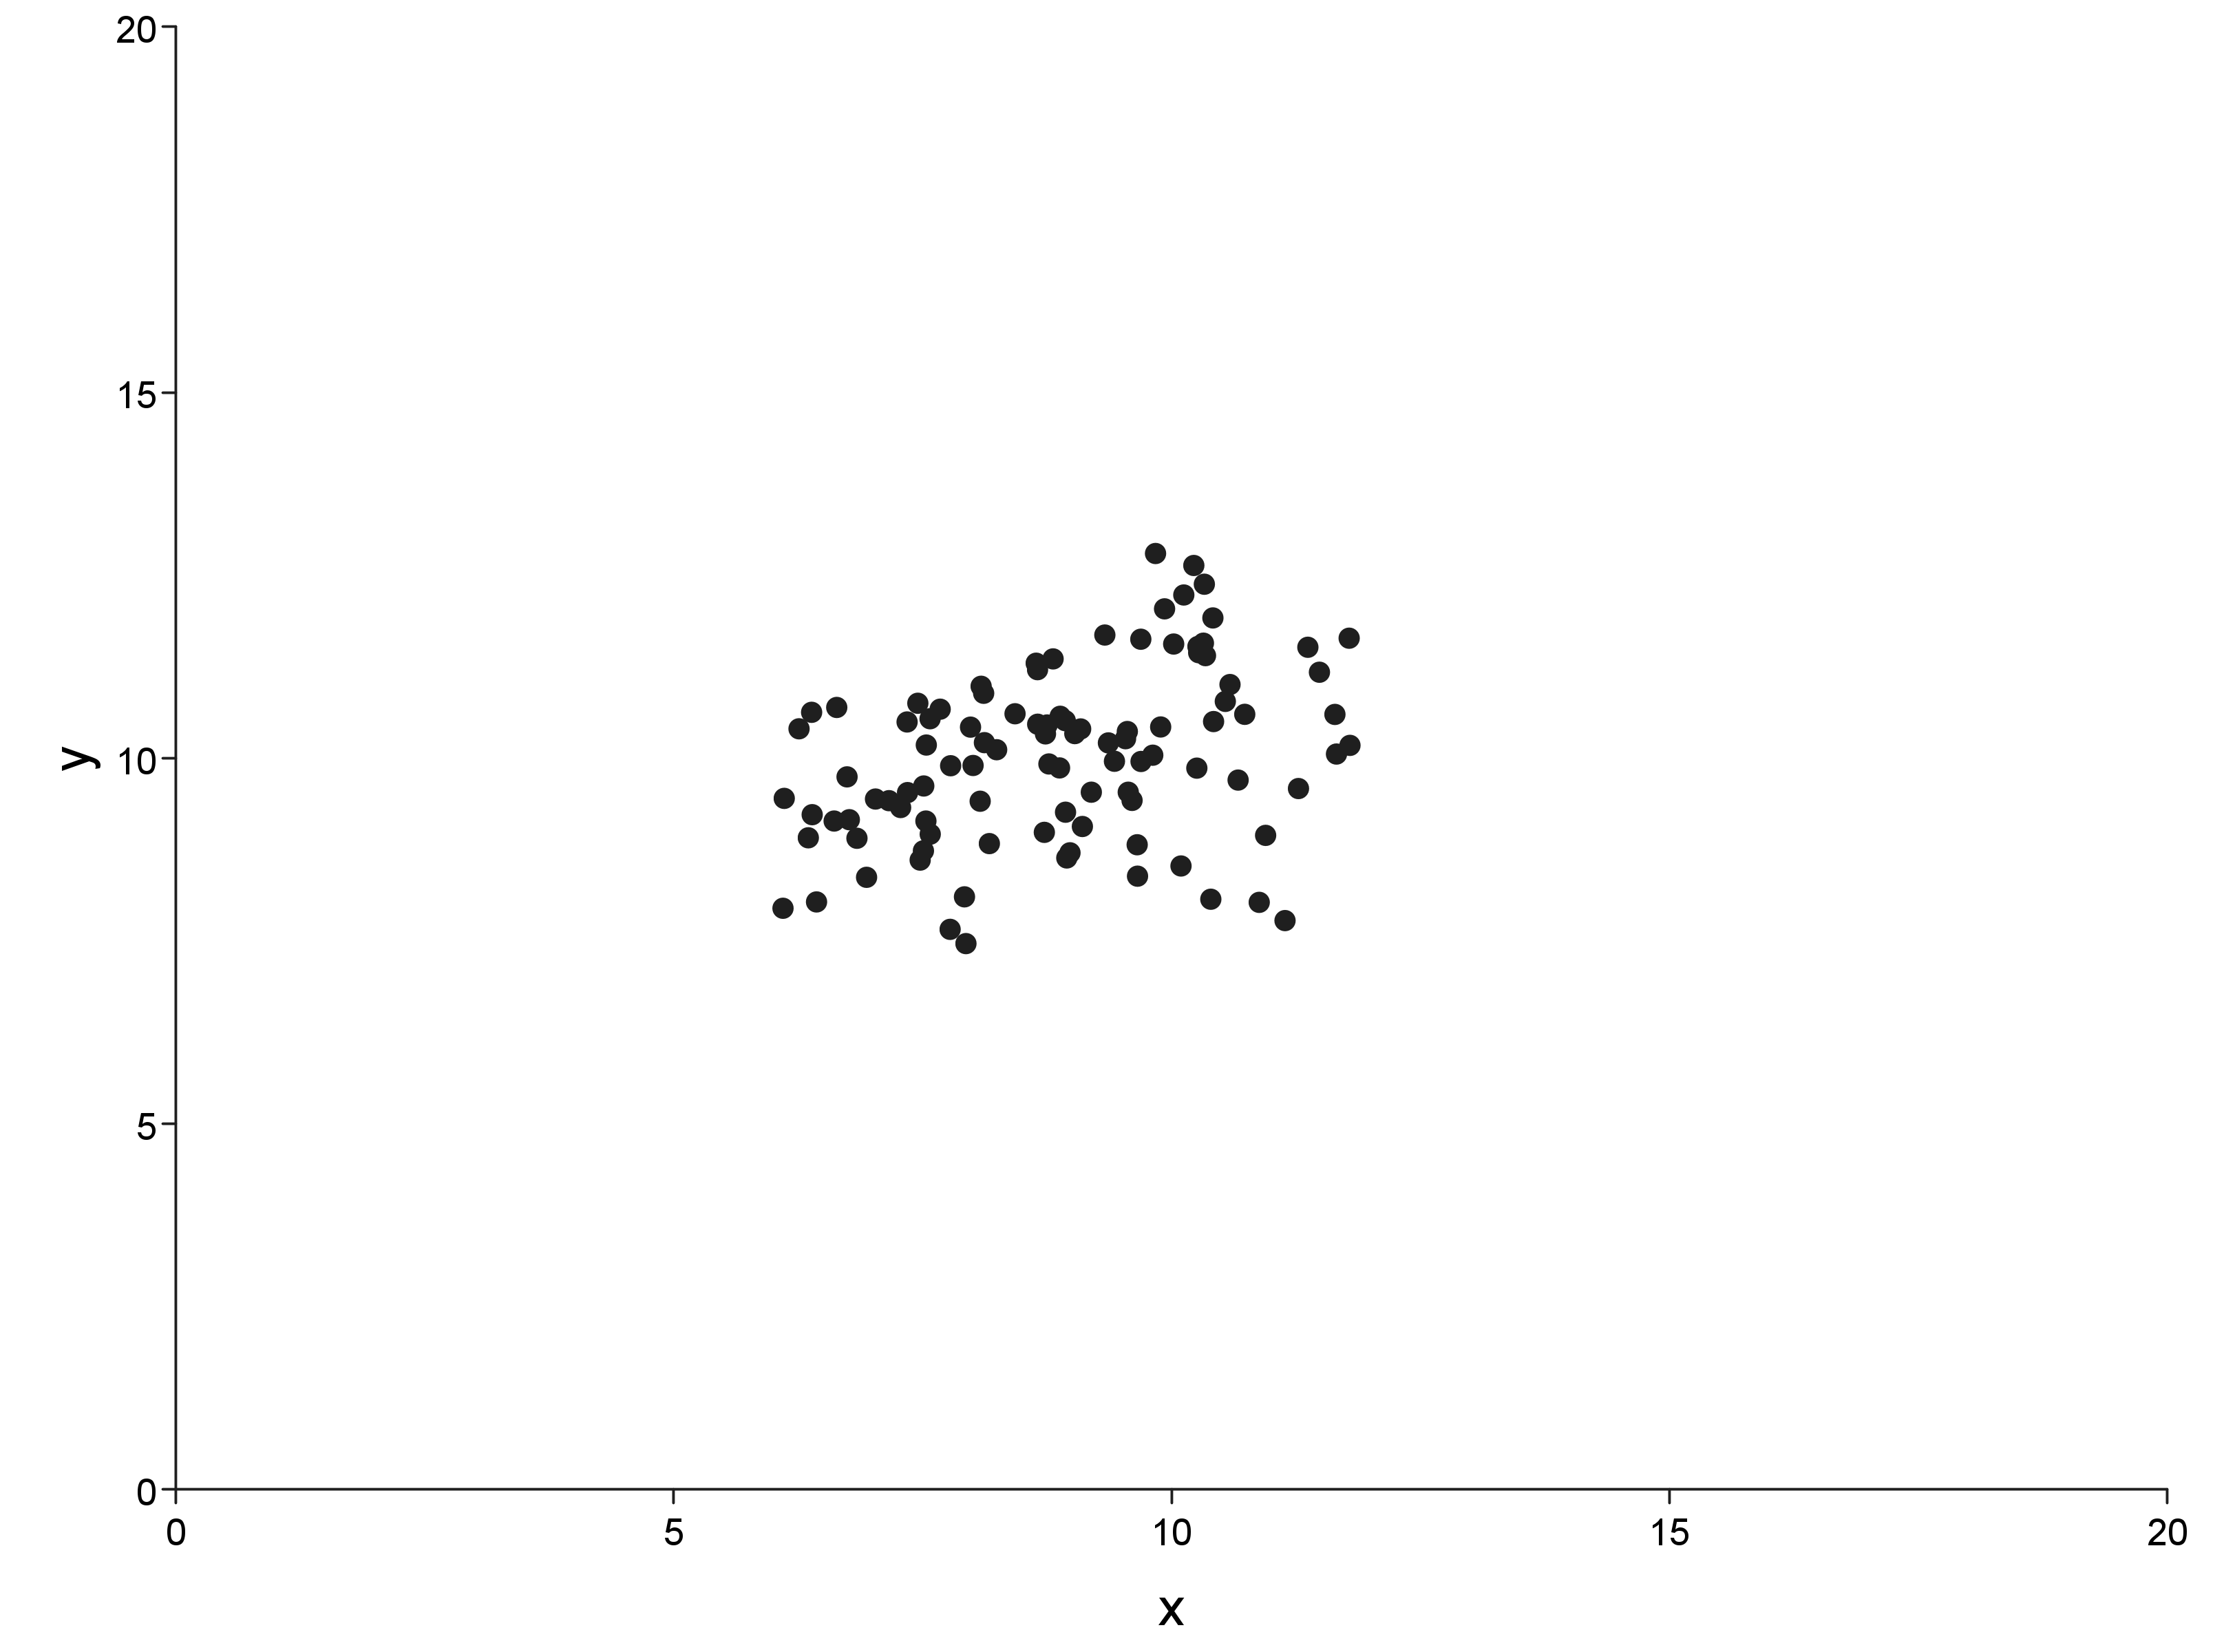

In [198]:
{{ // the {{ suppress are here to suppress the output from the definitions
    
val samples = for (_ <- 0 until 100) yield bivariateNormal.sample()
val plot = ScatterPlot(    
    samples.map(s => Point(s(0), s(1)))    
).xAxis()
 .yAxis()
 .frame()
 .xLabel("x")
 .xbounds(0, 20)
 .yLabel("y")
 .ybounds(0, 20)
 .rightLegend()
 .render()
showPlot(plot)
}}

We also need to define a proposal generator. We define a simple random walk proposal, which chooses the new direction and step length randomly.

In [217]:
def randomWalkProposal(x : State) : State = {
    val stepLength = 1.0
    
    val step = DenseVector(rng.nextGaussian() * stepLength, rng.nextGaussian() * stepLength)
    x + step
}

defined function randomWalkProposal

Now we can draw samples using our sampler. 

In [244]:
val logger = new Logger()
val samples = metropolisSampler(BivariateNormal.pdf, randomWalkProposal, DenseVector(10, 10), logger).take(200).toSeq

logger: Logger = ammonite.$sess.cmd192$Helper$Logger@4ba35ecc
samples: Seq[State] = List(
  DenseVector(10.0, 10.0),
  DenseVector(10.0, 10.0),
  DenseVector(10.99761915637973, 10.452263823820068),
  DenseVector(10.99761915637973, 10.452263823820068),
  DenseVector(10.503067998640702, 8.727362818121495),
  DenseVector(10.758380759176765, 8.758791655207531),
  DenseVector(10.48209473717009, 8.421055514806843),
  DenseVector(10.48209473717009, 8.421055514806843),
  DenseVector(10.178641431299614, 8.27140854128532),
  DenseVector(10.178641431299614, 8.27140854128532),
  DenseVector(8.801201993114454, 7.355358734229102),
  DenseVector(9.781019639181572, 8.560372682232064),
  DenseVector(9.781019639181572, 8.560372682232064),
  DenseVector(9.781019639181572, 8.560372682232064),
  DenseVector(8.458515803745602, 8.46631581945995),
  DenseVector(8.393669849995865, 9.29994626710759),
  DenseVector(9.518731161160618, 8.180811551705917),
  DenseVector(9.518731161160618, 8.180811551705917),
  Dens

Computing the mean and the covariance from the samples shows, that the samples approximate the target distribution rather well. 

In [243]:
val mean = samples.reduce(_ + _) * (1.0 / samples.length)
val cov = samples.map(x => (x - mean) * (x - mean).t).reduce(_ + _) * (1.0 / samples.length)

mean: DenseVector[Double] = DenseVector(8.560299887211764, 9.895662047027773)
cov: DenseMatrix[Double] = 1.0995973619559525  0.2122857576086259  
0.2122857576086259  0.5802414438065547  

We can also check this also visually by plotting the samples:

In [245]:
def plotSamples(samples : Seq[State]) : Image = {

    val plot = ScatterPlot(
        samples.map(s => Point(s(0), s(1)))
    )
    .xAxis()
    .xbounds(0, 20)
    .yAxis()
    .ybounds(0, 20)
    .frame()
    .xLabel("x")
    .yLabel("y")
    .rightLegend()
    .render()
    showPlot(plot)
}

defined function plotSamples

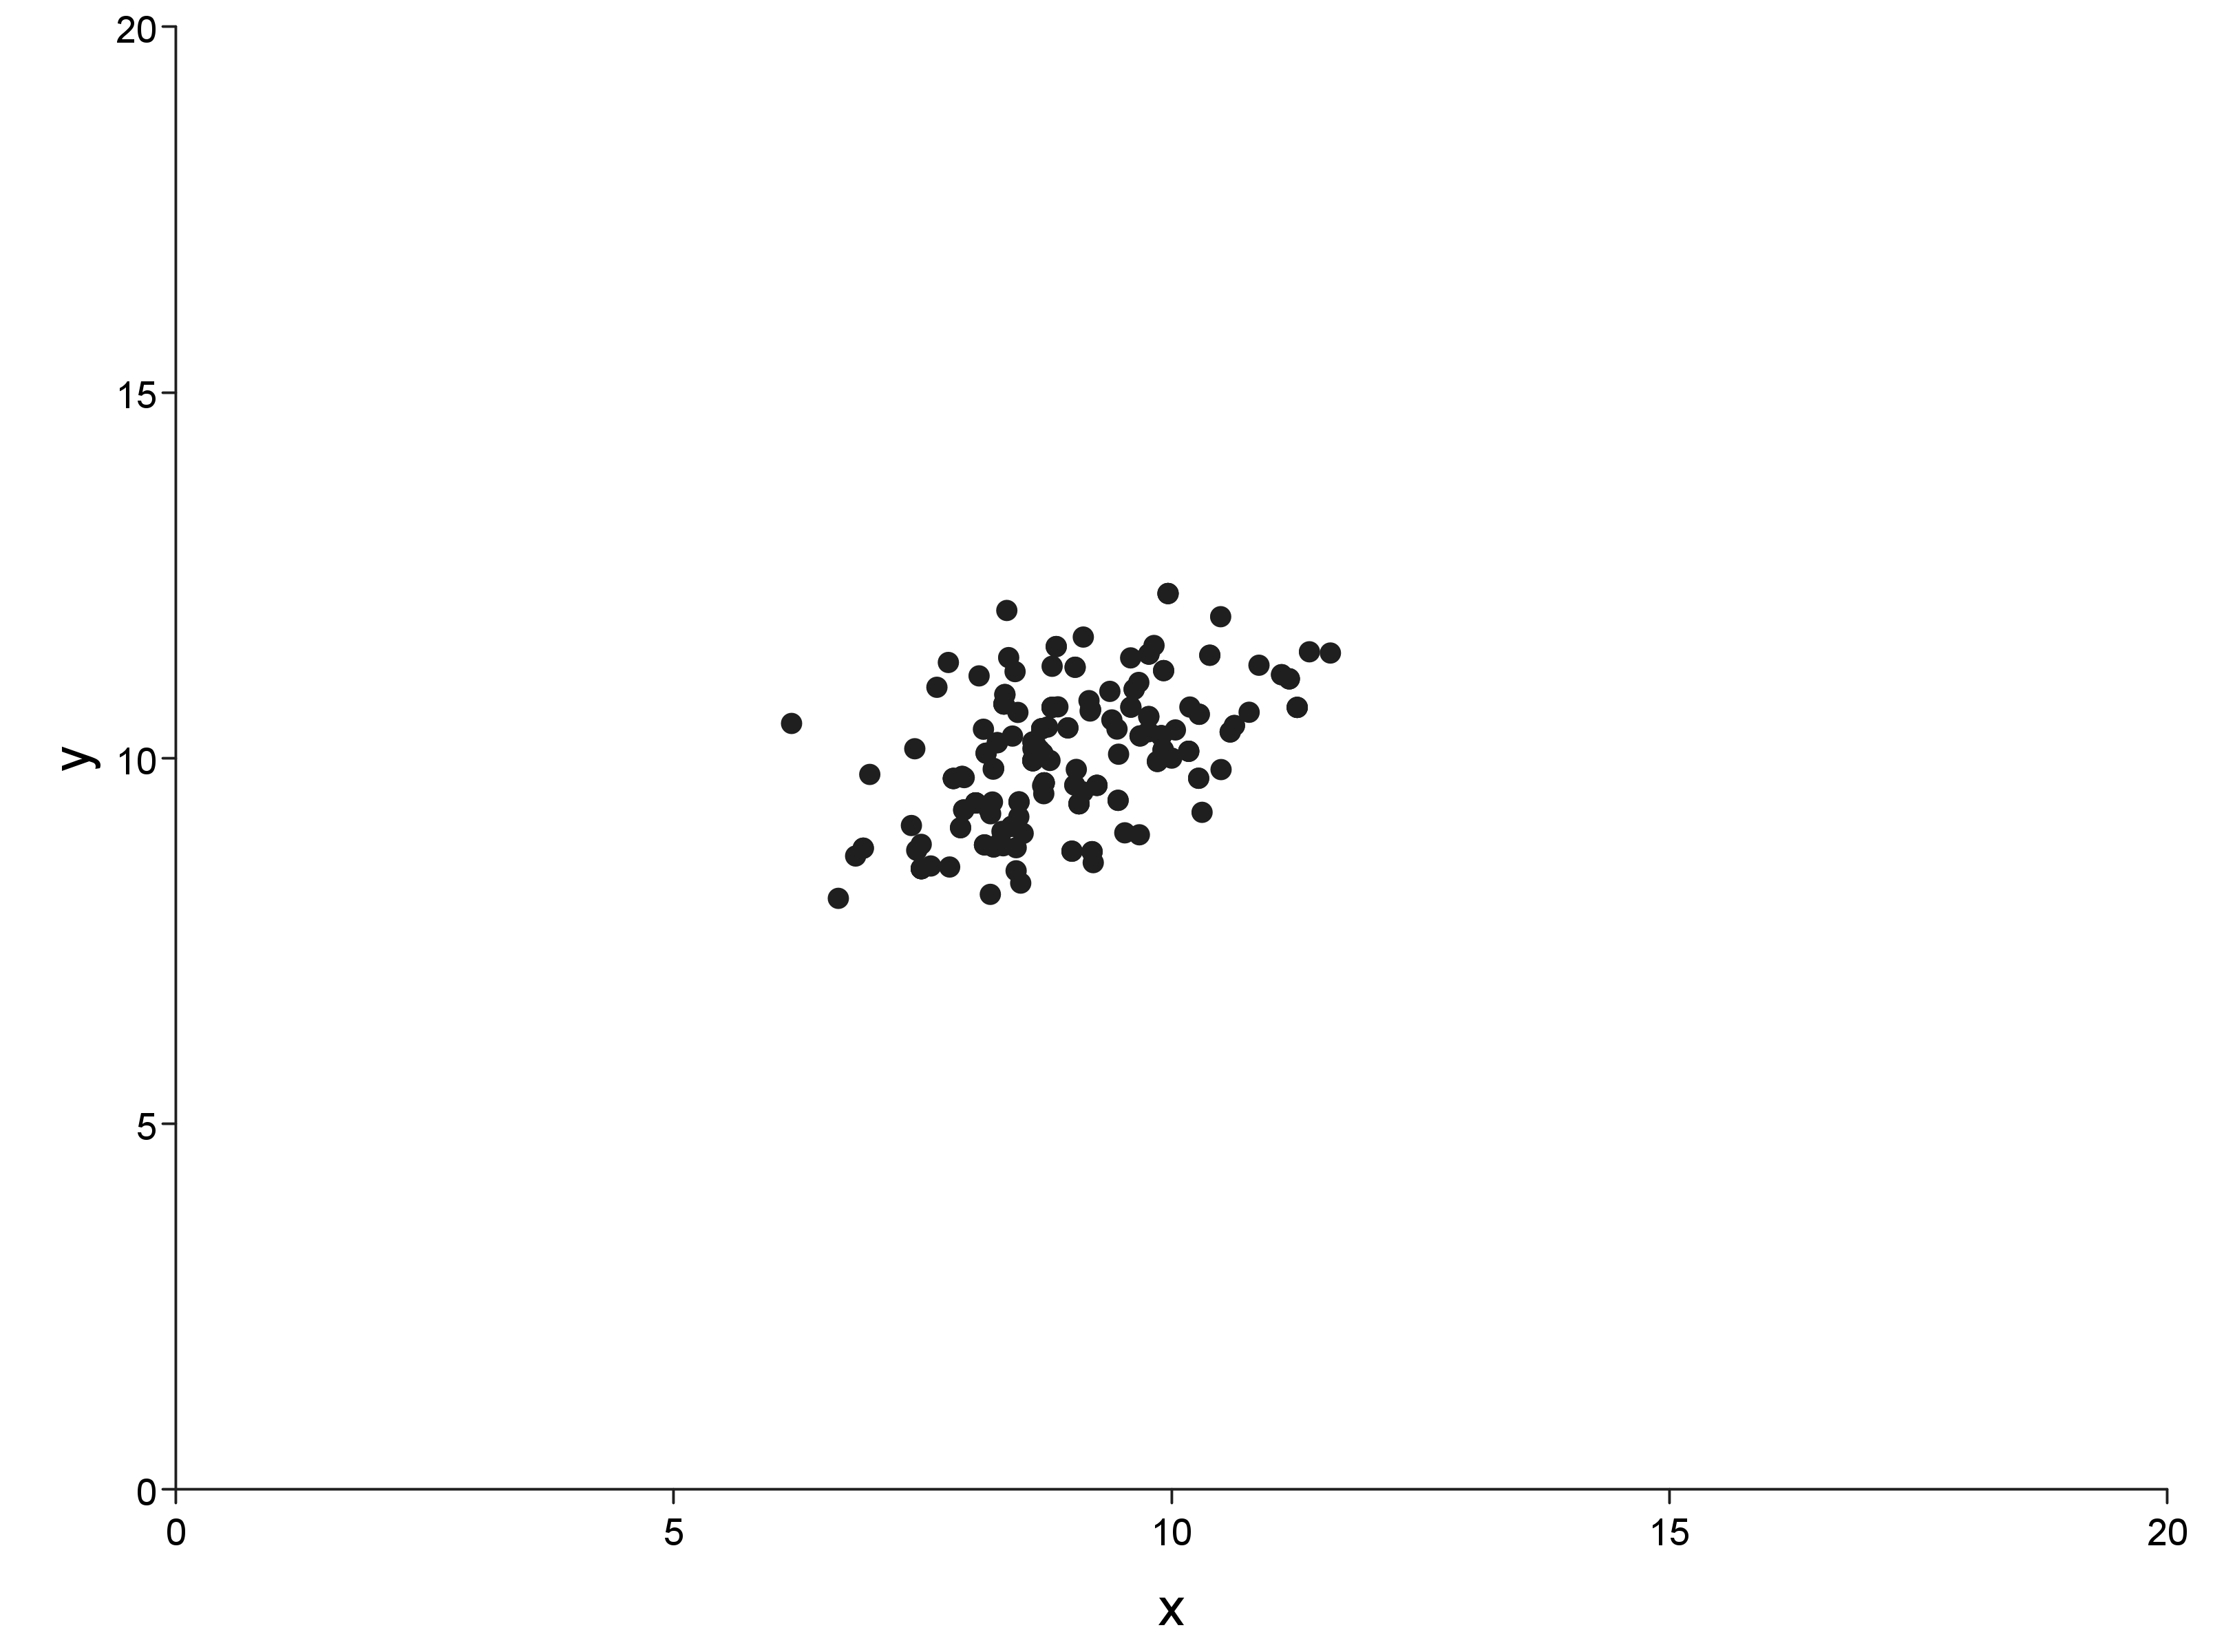

In [241]:
plotSamples(samples)

To get a deeper understanding of how the metropolis algorithm works, it is interesting to visualize not only the accepted samples, but also those which are rejected, and possibly the path that was taken. This is achieved by the following plot function, which visualizes the accepted and rejected samples in different colors and also can plot lines to show the path that was explored:

In [223]:
def plotLoggedSamples(logger : Logger, plotLines : Boolean = false) : Image = {

    val acceptedPlot = ScatterPlot.series(
        logger.steps.filter(s => s.accepted).map(s => Point(s.state(0), s.state(1))),
        "accepted", 
        HTMLNamedColors.blue, 
        pointSize = Some(3)
    )
    val rejectedPlot = ScatterPlot.series(
        logger.steps.filterNot(s => s.accepted).map(s => Point(s.proposedState(0), s.proposedState(1))),
        "rejected", 
        HTMLNamedColors.red ,
        pointSize = Some(3)  
    )
    val linePlot =  LinePlot(
        logger.steps.flatMap(s => 
                        if (!s.accepted) {        
                            Seq(Point(s.proposedState(0), s.proposedState(1)), Point(s.state(0), s.state(1)))
                        } else {
                            Seq(Point(s.state(0), s.state(1)))
                        })
    )
    
    var plots = Seq(acceptedPlot)
    plots = plots :+ rejectedPlot
    if (plotLines) plots = plots :+ linePlot
    
    val plot = Overlay.fromSeq(plots)
    .xAxis()
    .xbounds(0, 20)
    .yAxis()
    .ybounds(0, 20)
    .frame()
    .xLabel("x")
    .yLabel("y")
    .rightLegend()
    .render()
    showPlot(plot)
}

defined function plotLoggedSamples

We can now plot our samples and start experimenting:

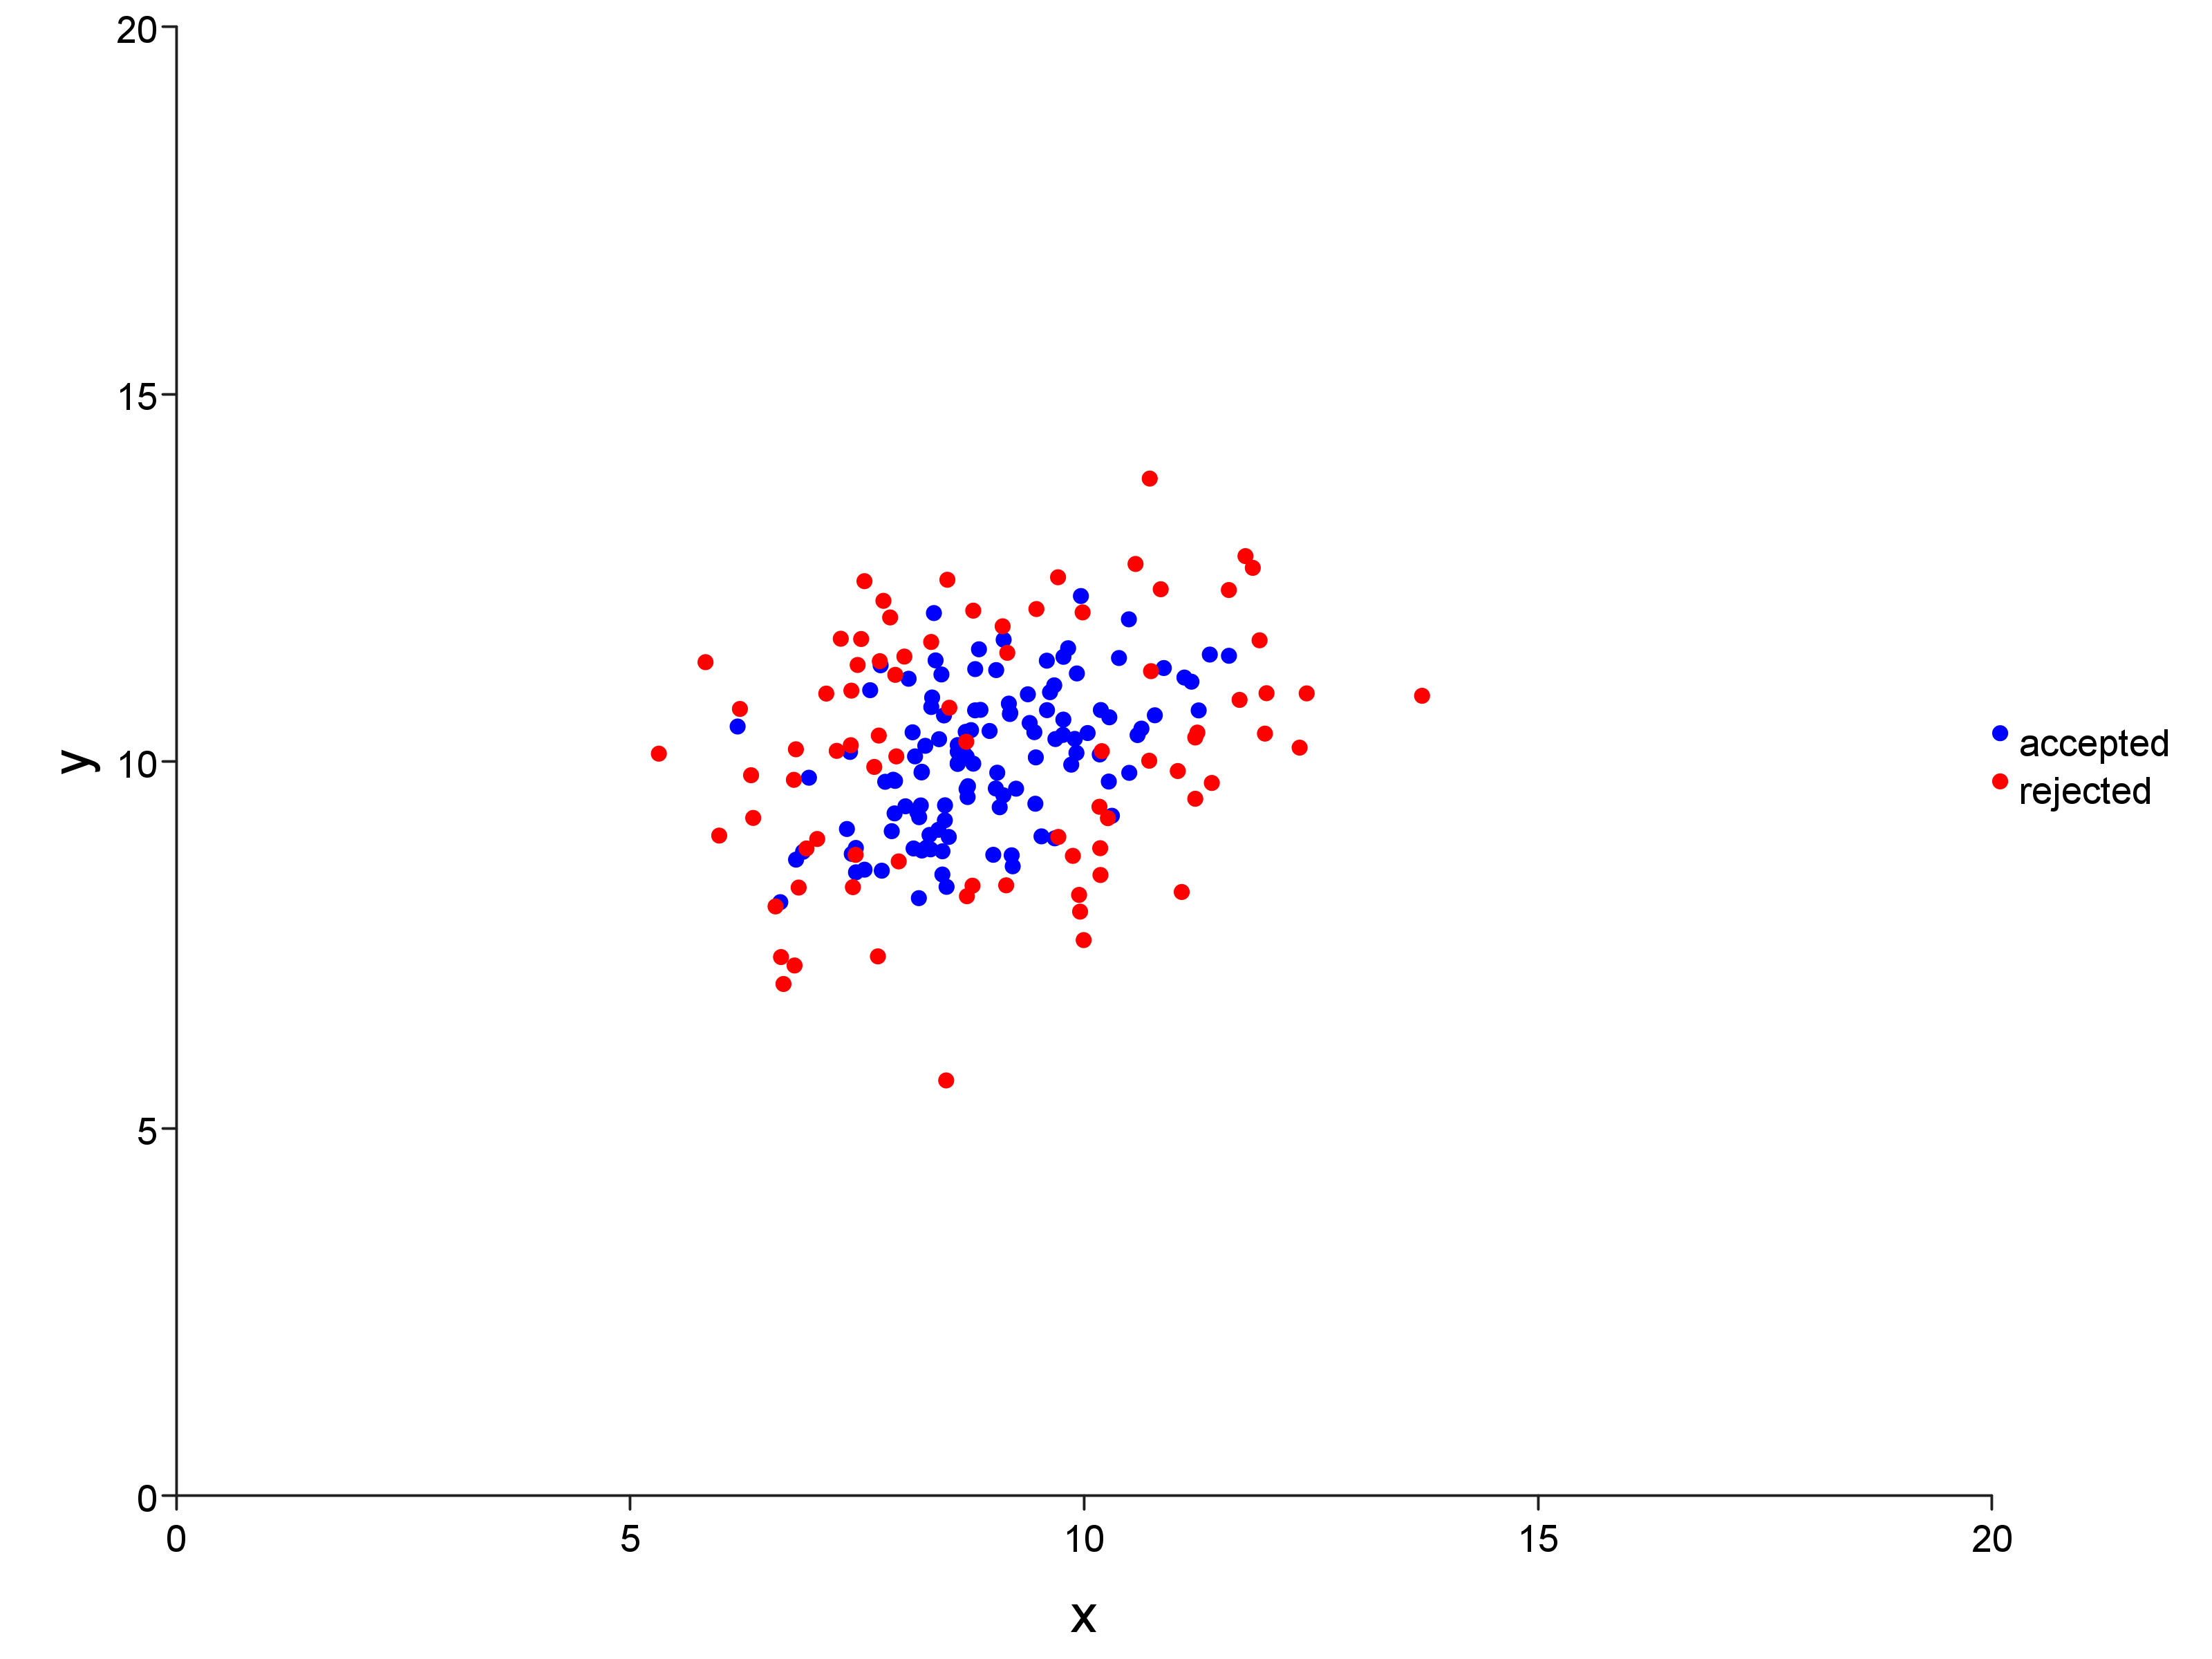

In [224]:
plotLoggedSamples(logger, plotLines = false)

#### Exercises

* We have started sampling from close to the mean of the target distribution. What happens when we start at the Point (0,0)?
    * Visualize the resulting samples using the plot functions
    * How could we mitigate the situation?
* Play with different step-length in the proposal.
    * What happens to the acceptance and rejection rate? 
    * How well is the target distribution approximated after a fixed number of samples
* Experiment with different target distributions. 
    * Make the variance larger and smaller
    * Change the correlation 
    * Assign to all samples whose x value is larger then 5 the probability 0. 
        * Do you need to normalize the pdf? why, why not?
* Define a function that computes the exected value of a given function, using the samples
* How could you get samples from the marginal distributions?